In [1]:
import json
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import ast
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# Code Generation

In [2]:
import random

# Function templates
function_templates = [
    """def process_list_{i}(lst):
    \"\"\"Process a list with filter, transform, and aggregation.\"\"\"
    filtered = [x for x in lst if x >= 0]
    squared = [x**2 for x in filtered]
    total = sum(squared)
    return total""",

    """def filter_and_double_dict_{i}(data):
    \"\"\"Filter dict values > 5 and double them.\"\"\"
    filtered = {{k:v for k,v in data.items() if v > 5}}
    doubled = {{k:v*2 for k,v in filtered.items()}}
    return doubled""",

    """def analyze_string_{i}(text):
    \"\"\"Analyze string length, vowels, and consonants.\"\"\"
    vowels = 'aeiouAEIOU'
    num_vowels = sum(1 for c in text if c in vowels)
    num_consonants = sum(1 for c in text if c.isalpha() and c not in vowels)
    return len(text), num_vowels, num_consonants""",

    """def pairwise_operations_{i}(lst):
    \"\"\"Compute sum and product of all unique pairs in a list.\"\"\"
    sums = [x+y for i,x in enumerate(lst) for y in lst[i+1:]]
    products = [x*y for i,x in enumerate(lst) for y in lst[i+1:]]
    return sums, products""",

    """def matrix_row_col_sums_{i}(matrix):
    \"\"\"Compute row sums and column sums of a matrix.\"\"\"
    row_sums = [sum(row) for row in matrix]
    col_sums = [sum(matrix[r][c] for r in range(len(matrix))) for c in range(len(matrix[0]))]
    return row_sums, col_sums""",

    """def filter_primes_{i}(numbers):
    \"\"\"Return only prime numbers from a list.\"\"\"
    def is_prime(n):
        if n < 2:
            return False
        for i in range(2,int(n**0.5)+1):
            if n % i == 0:
                return False
        return True
    primes = [n for n in numbers if is_prime(n)]
    return primes""",

    """class HistoryCounter_{i}:
    \"\"\"A counter that stores increment history.\"\"\"
    def __init__(self):
        self.count = 0
        self.history = []
    def increment(self, value=1):
        self.count += value
        self.history.append(value)
    def value(self):
        return self.count
    def get_history(self):
        return self.history""",

    """def fibonacci_memo_{i}(n, memo={{}}):
    \"\"\"Compute nth Fibonacci number with memoization.\"\"\"
    if n in memo:
        return memo[n]
    if n <= 1:
        memo[n] = n
    else:
        memo[n] = fibonacci_memo_{i}(n-1, memo) + fibonacci_memo_{i}(n-2, memo)
    return memo[n""",

    """def merge_and_sort_{i}(list1, list2):
    \"\"\"Merge two lists and sort the result.\"\"\"
    merged = list1 + list2
    merged.sort()
    return merged""",

    """def element_frequency_{i}(lst):
    \"\"\"Return a dictionary of element frequencies in a list.\"\"\"
    freq = {{x: lst.count(x) for x in set(lst)}}
    return freq"""
]

# Generate 500 samples
num_samples = 500
code_samples = []

for i in range(1, num_samples + 1):
    template = random.choice(function_templates)
    code = template.format(i=i)
    code_samples.append(code)

# Save as a Python file
with open("500_code.py", "w", encoding="utf-8") as f:
    for idx, code in enumerate(code_samples, 1):
        f.write(f"# Sample {idx}\n")
        f.write(code + "\n\n")

print("Generated 500 medium-complexity code samples in '500_code.py'.")


Generated 500 medium-complexity code samples in '500_code.py'.


#Docs Generation using LLM model

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "bigcode/starcoder2-3b"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

In [5]:
import json
import time

with open("500_code.py", "r", encoding="utf-8") as f:
    code_text = f.read()

samples = code_text.split("# Sample ")[1:]


In [6]:
generated_data = []

print("Generating docstrings using StarCoder2-3B\n")

for sample in samples:
    code_block = "\n".join(sample.strip().split("\n")[1:]).strip()

    prompt = (
        "Write a clear, detailed Python docstring for the following function.\n"
        "Describe arguments, behaviors, return values, and edge cases.\n\n"
        "### Code:\n"
        f"{code_block}\n\n"
        "### Docstring:\n\"\"\""
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.2,
        top_p=0.95,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    full_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract only the generated docstring part after """
    if "\"\"\"" in full_output:
        docstring = full_output.split("\"\"\"")[1].strip()
    else:
        docstring = full_output.strip()

    generated_data.append({
        "code": code_block,
        "generated_docstring": docstring
    })

    time.sleep(0.01)

print("DONE")


Generating docstrings using StarCoder2-3B

DONE


In [7]:
with open("500_code_with_docstrings.json", "w", encoding="utf-8") as f:
    json.dump(generated_data, f, indent=2, ensure_ascii=False)

print("Saved 500_code_with_docstrings.json")


Saved 500_code_with_docstrings.json


# Embeddings and Similarity Check

In [9]:
from sentence_transformers import SentenceTransformer, util
import torch


embedder = SentenceTransformer("all-MiniLM-L6-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
embedder.to(device)

print("Embedder loaded!\n")

similarity_results = []

print("Computing similarities...\n")

for item in generated_data:
    code = item["code"]
    doc = item["generated_docstring"]

    # Generate embeddings
    code_emb = embedder.encode(code, convert_to_tensor=True, device=device)
    doc_emb = embedder.encode(doc, convert_to_tensor=True, device=device)

    # Cosine similarity score
    sim = util.cos_sim(code_emb, doc_emb).item()

    # Store similarity
    item["similarity"] = float(sim)
    similarity_results.append(item)

print("Similarity computation complete")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedder loaded!

Computing similarities...

Similarity computation complete


In [10]:
consistent = []
inconsistent = []

threshold = 0.75

for item in similarity_results:
    if item["similarity"] >= threshold:
        consistent.append(item)
    else:
        inconsistent.append(item)

import json

with open("consistent.json", "w", encoding="utf-8") as f:
    json.dump(consistent, f, indent=2, ensure_ascii=False)

with open("inconsistent.json", "w", encoding="utf-8") as f:
    json.dump(inconsistent, f, indent=2, ensure_ascii=False)

print(f"Consistent samples: {len(consistent)}")
print(f"Inconsistent samples: {len(inconsistent)}")
print("Saved → consistent.json / inconsistent.json")


Consistent samples: 249
Inconsistent samples: 251
Saved → consistent.json / inconsistent.json


#Results Visualization

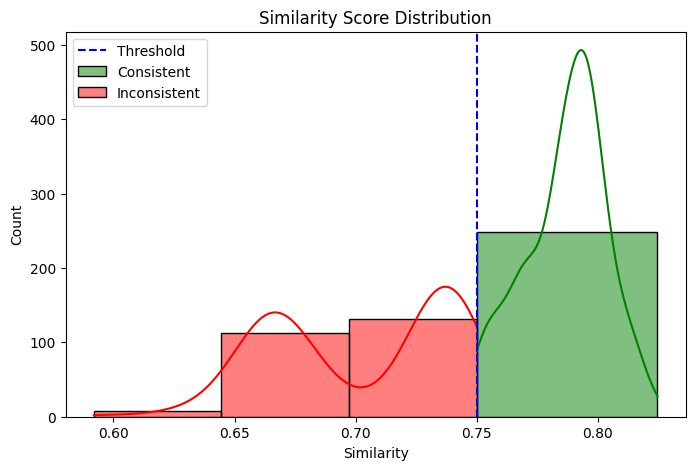

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract similarity scores
consistent_scores = [item["similarity"] for item in consistent]
inconsistent_scores = [item["similarity"] for item in inconsistent]

# Plot histogram
plt.figure(figsize=(8,5))
sns.histplot(consistent_scores, color='green', label='Consistent', kde=True, binwidth=0.05)
sns.histplot(inconsistent_scores, color='red', label='Inconsistent', kde=True, binwidth=0.05)
plt.axvline(threshold, color='blue', linestyle='--', label='Threshold')
plt.title("Similarity Score Distribution")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.legend()
plt.show()


/tmp/ipython-input-952072212.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette=['green','red'])


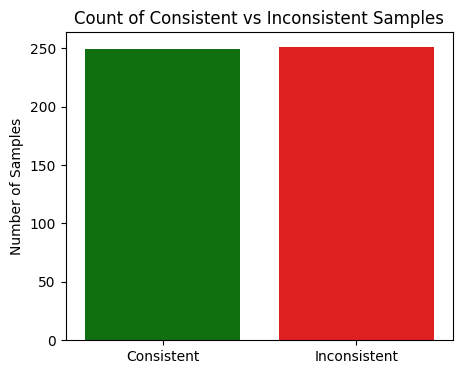

In [12]:
labels = ['Consistent', 'Inconsistent']
counts = [len(consistent), len(inconsistent)]

plt.figure(figsize=(5,4))
sns.barplot(x=labels, y=counts, palette=['green','red'])
plt.title("Count of Consistent vs Inconsistent Samples")
plt.ylabel("Number of Samples")
plt.show()


In [20]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON files
with open("consistent.json", "r", encoding="utf-8") as f:
    consistent = json.load(f)

with open("inconsistent.json", "r", encoding="utf-8") as f:
    inconsistent = json.load(f)

# Show a few examples
print("=== Consistent Examples ===")
for sample in consistent[:3]:  # first 3 examples
    print(f"ID: {sample.get('id', 'N/A')}, Similarity: {sample['similarity']}")
    print("Code:", sample['code'])
    print("-"*20)

print("\n=== Inconsistent Examples ===")
for sample in inconsistent[:3]:  # first 3 examples
    print(f"ID: {sample.get('id', 'N/A')}, Similarity: {sample['similarity']}")
    print("Code:", sample['code'])
    print("-"*20)

=== Consistent Examples ===
ID: N/A, Similarity: 0.81150883436203
Code: def merge_and_sort_2(list1, list2):
    """Merge two lists and sort the result."""
    merged = list1 + list2
    merged.sort()
    return merged
--------------------
ID: N/A, Similarity: 0.7957128286361694
Code: def merge_and_sort_6(list1, list2):
    """Merge two lists and sort the result."""
    merged = list1 + list2
    merged.sort()
    return merged
--------------------
ID: N/A, Similarity: 0.7695724368095398
Code: def fibonacci_memo_7(n, memo={}):
    """Compute nth Fibonacci number with memoization."""
    if n in memo:
        return memo[n]
    if n <= 1:
        memo[n] = n
    else:
        memo[n] = fibonacci_memo_7(n-1, memo) + fibonacci_memo_7(n-2, memo)
    return memo[n
--------------------

=== Inconsistent Examples ===
ID: N/A, Similarity: 0.749323844909668
Code: def matrix_row_col_sums_1(matrix):
    """Compute row sums and column sums of a matrix."""
    row_sums = [sum(row) for row in matrix]

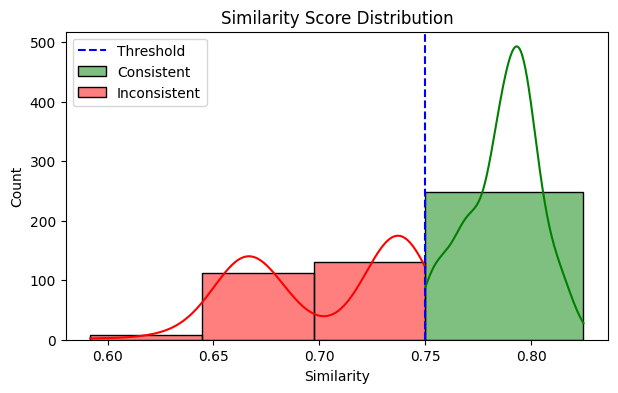

In [21]:
# Prepare data for visualization
scores_consistent = [s["similarity"] for s in consistent]
scores_inconsistent = [s["similarity"] for s in inconsistent]

# Plot histogram of similarity scores
plt.figure(figsize=(7,4))
sns.histplot(scores_consistent, color='green', label='Consistent', kde=True, binwidth=0.05)
sns.histplot(scores_inconsistent, color='red', label='Inconsistent', kde=True, binwidth=0.05)
plt.axvline(0.75, color='blue', linestyle='--', label='Threshold')
plt.title("Similarity Score Distribution")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.legend()
plt.show()

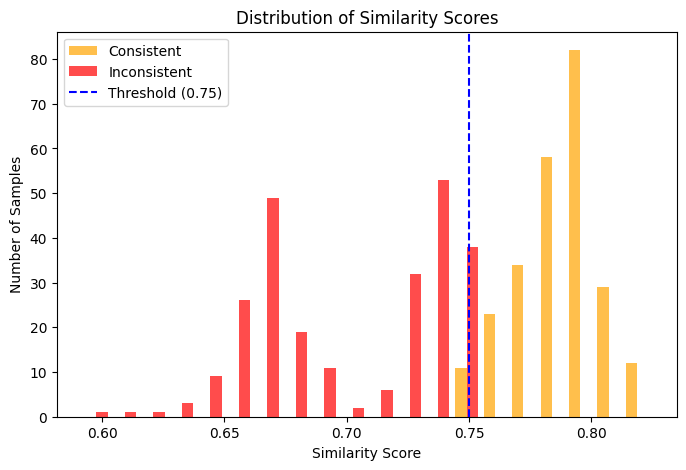

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert lists to DataFrame for easier plotting
df_consistent = pd.DataFrame(consistent)
df_inconsistent = pd.DataFrame(inconsistent)

# Combine for plotting
df_consistent['label'] = 'Consistent'
df_inconsistent['label'] = 'Inconsistent'
df_plot = pd.concat([df_consistent, df_inconsistent])

# Plot similarity distribution
plt.figure(figsize=(8,5))
plt.hist(
    [df_consistent['similarity'], df_inconsistent['similarity']],
    bins=20,
    color=['orange','red'],
    label=['Consistent','Inconsistent'],
    alpha=0.7
)
plt.axvline(x=0.75, color='blue', linestyle='--', label='Threshold (0.75)')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.show()

